# 1. Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import h5py
import math
import sklearn
import sklearn.datasets

# 2. Help functions

## 2.1 Initialization

In [2]:
'''
model dimensions = [n0, n2, ..., nL]
parameters = {
              "W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,  
              ...
              "WL": WL,
              "bL": bL,
                }
'''
def xavier_init(layers_dims, l):  # for tanh
    return np.sqrt(1./layers_dims[l])

def he_init(layers_dims, l):  # for Relu
    return np.sqrt(2./layers_dims[l])

def param_init(layers_dims,init_function=xavier_init):
    parameters = {}
    for l in range(len(layers_dims)-1):
        parameters[f"W{l+1}"] = np.random.randn(layers_dims[l+1],layers_dims[l])*init_function(layers_dims, l)
        parameters[f"b{l+1}"] = np.zeros((layers_dims[l+1], 1))
    return parameters

## 2.2 Forward

### 2.2.1 Linear function

$$Z^{[l]} = W^{[l]}\cdot A^{[l-1]}+b^{[l]}$$

In [3]:
def linear_fw(A_prev, W, b):
    Z = np.dot(W, A_prev)+b
    cache = {"A_prev":A_prev, "W":W, "b":b}
    return Z, cache

### 2.2.2 Activation

$$\sigma(z) = \frac{1}{1+e^{-z}}$$


$$\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$$


$$\mathrm{relu}(z) = \max(0,z)$$

In [4]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache


def relu(Z):
    A = np.maximum(0,Z)
    cache = Z
    return A, cache


def tanh(Z):
    A = (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
    cache = Z
    return A, cache

### 2.2.3 Linear activation forward

In [5]:
def linear_activation_fw(A_prev, W, b, activation):
    Z, linear_cache = linear_fw(A_prev, W, b)
    
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "tanh":
        A, activation_cache = tanh(Z)    
        
    cache = {"linear_cache": linear_cache, "activation_cache":activation_cache}
    return A, cache

### 2.2.4 Forward propagation

In [6]:
def forward_prop(X, parameters, hidden="relu"):
    '''
    parameters = {
                  "W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,  
                  ...
                  "WL": WL,
                  "bL": bL,
                    }
    '''    
    caches = []
    L = len(parameters)//2
    A = X
    for l in range(L-1):
        A_prev = A
        A, cache = linear_activation_fw(A_prev, parameters[f"W{l+1}"], parameters[f"b{l+1}"], hidden)
        caches.append(cache)
    AL, cache = linear_activation_fw(A, parameters[f"W{L}"], parameters[f"b{L}"], "sigmoid")
    caches.append(cache)
    return AL, caches

## 2.3 Backward

### 2.3.0 Cost function

$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right))$$

In [7]:
def cross_entropy_cost(AL, Y):
    m = Y.shape[1]
    cost = -(1/m)*np.sum(np.dot(Y, np.log(AL.T)) + np.dot((1-Y),np.log(1-AL).T))
    cost = np.squeeze(cost)
    return cost

### 2.3.1 Activation function backward

$$dZ^{[l]} = dA^{[l]}\times g'^(Z^{[l]})$$

In [8]:
def sigmoid_deriv(Z):
    s = 1/(1+np.exp(-Z))
    deriv = s * (1-s)
    return deriv

def relu_deriv(Z):
    deriv = Z.copy()
    deriv[Z <= 0] = 0
    deriv[Z > 0] = 1
    return deriv

def tanh_deriv(Z):
    t = (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
    deriv = 1-t**2
    return deriv

def activation_bw(dA, cache, deriv):
    Z = cache
    dZ = dA*deriv(Z)
    return dZ

### 2.3.2 Linear function backward

$$dW^{[l]} = \frac{1}{m}dZ^{[l]}A^{[l-1]T}$$

$$ db^{[l]} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$$

$$ dA^{[l-1]} = W^{[l] T} dZ^{[l]}$$

In [9]:
def linear_bw(dZ, cache):
    A_prev = cache['A_prev']
    W = cache['W']
    b = cache['b']
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

### 2.3.3 Activation linear backward

In [10]:
def activation_linear_bw(dA, cache, activation):
    linear_cache = cache['linear_cache']
    activation_cache = cache['activation_cache'] 
    if activation == "relu":
        dZ = activation_bw(dA, activation_cache, relu_deriv)       
    elif activation == "sigmoid":
        dZ = activation_bw(dA, activation_cache, sigmoid_deriv)
    elif activation == "tanh":
        dZ = activation_bw(dA, activation_cache, tanh_deriv)
    dA_prev, dW, db = linear_bw(dZ, linear_cache)
    return dA_prev, dW, db

### 2.3.4 Backward propagation

$$dA^{[L]} = -\frac{y}{A^{[L]}}+\frac{1-y}{1-A^{[L]}}$$

In [11]:
def backward_prop(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))  
    
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = activation_linear_bw(dAL, current_cache, "sigmoid")
    grads[f"dA{L-1}"] = dA_prev_temp
    grads[f"dW{L}"] = dW_temp
    grads[f"db{L}"] = db_temp

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = activation_linear_bw(dA_prev_temp, current_cache, "relu")
        grads[f"dA{l}"] = dA_prev_temp
        grads[f"dW{l+1}"] = dW_temp
        grads[f"db{l+1}"] = db_temp        
    return grads

## 2.5 Update parameters

### 2.5.0 Basic update

In [12]:
def update_parameters(params, grads, learning_rate):
    parameters = params.copy()
    L = len(parameters) // 2 

    for l in range(L):
        parameters[f"W{l+1}"] = parameters[f"W{l+1}"] - learning_rate*grads[f"dW{l+1}"]
        parameters[f"b{l+1}"] = parameters[f"b{l+1}"] - learning_rate*grads[f"db{l+1}"]
    return parameters

### 2.5.1 Update with Adam

$$v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) dW^{[l]}$$

$$v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t}$$

$$s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) dW^{[l]^2}$$

$$s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t}$$

$$W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}$$

In [13]:
def initialize_adam(parameters) :
    L = len(parameters) // 2 
    v = {}
    s = {}
    for l in range(1, L + 1):
        v["dW" + str(l)] = np.zeros((parameters["W" + str(l)].shape))
        v["db" + str(l)] = np.zeros((parameters["b" + str(l)].shape))
        s["dW" + str(l)] = np.zeros((parameters["W" + str(l)].shape))
        s["db" + str(l)] = np.zeros((parameters["b" + str(l)].shape))  
    return v, s


def update_parameters_with_adam(params, grads, v, s, t, learning_rate,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    parameters = params.copy()
    L = len(parameters) // 2 
    v_corrected = {}
    s_corrected = {}
    for l in range(L):
        v[f"dW{l+1}"] = beta1*v[f"dW{l+1}"] + (1-beta1)*grads[f"dW{l+1}"]
        v[f"db{l+1}"] = beta1*v[f"db{l+1}"] + (1-beta1)*grads[f"db{l+1}"]
        v_corrected[f"dW{l+1}"] = v[f"dW{l+1}"]/(1-beta1**t)
        v_corrected[f"db{l+1}"] = v[f"db{l+1}"]/(1-beta1**t)    
        s[f"dW{l+1}"] = beta2*s[f"dW{l+1}"] + (1-beta2)*(grads[f"dW{l+1}"]**2)
        s[f"db{l+1}"] = beta2*s[f"db{l+1}"] + (1-beta2)*(grads[f"db{l+1}"]**2)  
        s_corrected[f"dW{l+1}"] = s[f"dW{l+1}"]/(1-beta2**t)
        s_corrected[f"db{l+1}"] = s[f"db{l+1}"]/(1-beta2**t) 
        
        parameters[f"W{l+1}"] = parameters[f"W{l+1}"] - learning_rate*(v_corrected[f"dW{l+1}"]/(np.sqrt(s_corrected[f"dW{l+1}"])+epsilon))
        parameters[f"b{l+1}"] = parameters[f"b{l+1}"] - learning_rate*(v_corrected[f"db{l+1}"]/(np.sqrt(s_corrected[f"db{l+1}"])+epsilon))
    return parameters, v, s, v_corrected, s_corrected

## 2.6 L2 Regularization

### 2.6.1 Cost with L2 regularization

$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

In [14]:
def cross_entropy_cost_L2(AL, Y, parameters, lambd):
    m = Y.shape[1]
    L = len(parameters) // 2 
    ce_cost = cross_entropy_cost(AL, Y)
    L2_cost = 0  # l2 regularization
    for l in range(1,L+1):
        L2_cost += np.sum(np.square(parameters[f"W{l}"]))
    L2_regularization_cost = (1/m)*(lambd/2)*L2_cost
    cost = ce_cost + L2_regularization_cost
    return cost

### 2.6.2 Backward propagation with L2 regularization

$$dW^{[l]}=\frac{1}{m}dZ^{[l]}A^{[l-1]T}+ \frac{\lambda}{m} W^{[l]}$$

In [15]:
def linear_bw_L2(dZ, cache, lambd):
    A_prev = cache['A_prev']
    W = cache['W']
    b = cache['b']
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ,A_prev.T) + (lambd/m)*W # l2 regularization
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db


def activation_linear_bw_L2(dA, cache, activation, lambd):
    linear_cache = cache['linear_cache']
    activation_cache = cache['activation_cache'] 
    if activation == "relu":
        dZ = activation_bw(dA, activation_cache, relu_deriv)       
    elif activation == "sigmoid":
        dZ = activation_bw(dA, activation_cache, sigmoid_deriv)
    elif activation == "tanh":
        dZ = activation_bw(dA, activation_cache, tanh_deriv)
    dA_prev, dW, db = linear_bw_L2(dZ, linear_cache, lambd)
    return dA_prev, dW, db


def backward_prop_L2(AL, Y, caches,lambd):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))  
    
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = activation_linear_bw_L2(dAL, current_cache, "sigmoid", lambd)
    grads[f"dA{L-1}"] = dA_prev_temp
    grads[f"dW{L}"] = dW_temp
    grads[f"db{L}"] = db_temp

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = activation_linear_bw_L2(dA_prev_temp, current_cache, "relu", lambd)
        grads[f"dA{l}"] = dA_prev_temp
        grads[f"dW{l+1}"] = dW_temp
        grads[f"db{l+1}"] = db_temp        
    return grads

# 3. Model

## 3.1 Learning rate decay

In [17]:
def lr_decay(learning_rate0, epoch_num, decay_rate, time_interval=100): # lr decay
    
    learning_rate = learning_rate0*(1/(1+decay_rate*np.floor(epoch_num/time_interval)))
    
    return learning_rate

## 3.2 Mini batch

In [19]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
        
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))
    
    inc = mini_batch_size

    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:,k*inc:(k+1)*inc]
        mini_batch_Y = shuffled_Y[:,k*inc:(k+1)*inc]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    if m % mini_batch_size != 0:

        mini_batch_X = shuffled_X[:,num_complete_minibatches*inc:]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches*inc:]       

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

## 3.3 Model function

In [20]:
def model(X, Y, layers_dims, optimizer="gd",init_function=xavier_init, lambd=0, learning_rate = 0.1, mini_batch_size = 64, 
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, print_cost = True, decay=lr_decay, decay_rate=0.3):

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = X.shape[1]                   # number of training examples
    lr_rates = []
    learning_rate0 = learning_rate   # the original learning rate
    
    parameters = param_init(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    for i in range(num_epochs):
        
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:

            (minibatch_X, minibatch_Y) = minibatch
            
            aL, caches = forward_prop(minibatch_X, parameters)
            
            if lambd == 0:
                cost = cross_entropy_cost(aL, minibatch_Y)
            else:
                cost = cross_entropy_cost_L2(aL, minibatch_Y, parameters, lambd)
            cost_total += cost
            if math.isnan(cost_total):
                print("param:",parameters, "v:",v, "s",s, "t:",t, "aL:", aL, "current batch cost:",cost, "all costs:", costs)
                break
            if lambd == 0:
                grads = backward_prop(aL, minibatch_Y, caches)
            else:
                grads = backward_prop_L2(aL, minibatch_Y, caches, lambd)

            if optimizer == "gd":
                parameters = update_parameters(parameters, grads, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m

        if decay:
            learning_rate = decay(learning_rate0, i, decay_rate)
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
            if decay:
                print("learning rate after epoch %i: %f"%(i, learning_rate))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)

    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

## 3.3 Using model

In [24]:
def predict(X, y, parameters):
    m = X.shape[1]
    p = np.zeros((1,m), dtype = int)
    # Forward propagation
    a3, caches = forward_prop(X, parameters)
    # convert probas to 0/1 predictions
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

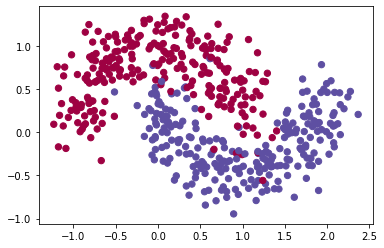

In [21]:
def load_dataset(n_samples):
    train_X, train_Y = sklearn.datasets.make_moons(n_samples=n_samples, noise=.2)
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    
    return train_X, train_Y

train_X, train_Y = load_dataset(500)

Cost after epoch 0: 0.010855
learning rate after epoch 0: 0.100000
Cost after epoch 1000: 0.002821
learning rate after epoch 1000: 0.025000
Cost after epoch 2000: 0.002840
learning rate after epoch 2000: 0.014286
Cost after epoch 3000: 0.002814
learning rate after epoch 3000: 0.010000
Cost after epoch 4000: 0.002806
learning rate after epoch 4000: 0.007692


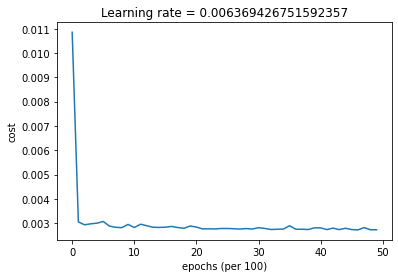

In [22]:
layers_dims = [train_X.shape[0], 5, 2, 1]
# L2 regularization with lambda = 0.2 and optimization with adam
parameters = model(train_X, train_Y,layers_dims,decay=lr_decay,num_epochs=5000,lambd=0.2,optimizer="adam")

## 3.4 View result

In [26]:
def predict_dec(parameters, X):
    a3, cache = forward_prop(X, parameters)
    predictions = (a3 > 0.5)
    return predictions

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

Accuracy: 0.96


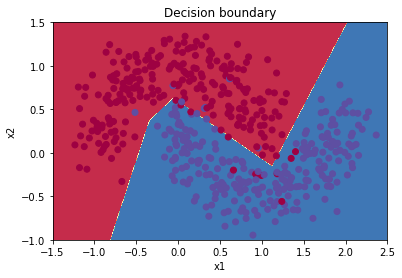

In [27]:
# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Decision boundary")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)